# Hyperparameter Tuning with Keras Tuner for the DNN

We performed hyperparameter tuning to find the optimal number of neurons in each dense layer.

Best results: 320 for first layer and 224 for the second layer.

We then use this in the final DNN model.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    recall_score,
    roc_curve,
    roc_auc_score,
)
import shap

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.metrics import AUC
import keras_tuner as kt
from utils.data import load_and_preprocess_data
from sklearn.model_selection import GroupShuffleSplit
from utils.constants import NUMERICAL_FEATURES, RANDOM_SEED
from utils.plots import (
    plot_training_validation_auc,
    plot_training_validation_loss,
    plot_roc_curve,
)

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pipeline Configuration

In [2]:
random_seed = RANDOM_SEED  # Random seed to ensure reproducibility
output_path = "output/tf_hyperparameter_tuning/"
cmap = "seismic"  # Colormap for SHAP plots use "seismic" for full cohort and "berlin" for biochem remission cohort
file_prefix = "tensorflow"
# file_prefix = "biochem_remission"

## Standardised Data Loading, Preprocessing and Splitting

In [3]:
df = load_and_preprocess_data() # pass biochem=True to use only biochem remission cohort

# Optimisation
columns_to_drop = [
    "baseline_eims_arthralgia_arthritis",
    "baseline_eims_ankylosing_spondylitis",
    "baseline_eims_erythema_nodosum",
    "baseline_eims_uveitis",
    "baseline_eims_scleritis_episclerities",
    "is_smoker_smokeryn1",
    "study_group_name_Await Dx",
    "ifx_drug_level",
    "ada_drug_level",
    "ifx_drug_level_present",
    "ada_drug_level_present",
    "ifx_antibody_present",
    "ada_antibody_present",
    "haematocrit",
]

df.drop(columns=columns_to_drop, inplace=True)

numerical_features = NUMERICAL_FEATURES
numerical_features = [col for col in numerical_features if col not in ['haematocrit', 'ada_drug_level', 'ifx_drug_level']]

In [4]:
# Create Train Validate and Test Datasets

# First split into train and temp 70% train, 30% temp which will be split 50:50 into 15% val and 15% test

# GroupShuffleSplit
splitter = GroupShuffleSplit(test_size=0.36, n_splits=1, random_state=random_seed)

# Perform the split
for train_idx, test_idx in splitter.split(df, groups=df["study_id"]):
    train_data = df.iloc[train_idx]
    temp_data = df.iloc[test_idx]

# Drop 'study_id' from X_train and X_test as it's not a feature
X_train = train_data.drop(columns=["fatigue_outcome", "study_id"])
y_train = train_data["fatigue_outcome"]

groups = train_data["study_id"]  # Group variable for GroupKFold cross-validation

temp_data_splitter = GroupShuffleSplit(
    test_size=0.56, n_splits=1, random_state=random_seed
)

# Perform the split
for val_idx, test_idx in temp_data_splitter.split(
    temp_data, groups=temp_data["study_id"]
):
    val_data = df.iloc[val_idx]
    test_data = df.iloc[test_idx]

X_val = val_data.drop(columns=["fatigue_outcome", "study_id"])
y_val = val_data["fatigue_outcome"]

X_test = test_data.drop(columns=["fatigue_outcome", "study_id"])
y_test = test_data["fatigue_outcome"]


print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)
print("Y train shape:", y_train.shape)
print("Y val shape:", y_val.shape)
print("Y test shape:", y_test.shape)

Train shape: (768, 65)
Val shape: (186, 65)
Test shape: (261, 65)
Y train shape: (768,)
Y val shape: (186,)
Y test shape: (261,)


In [5]:
# Normalize the numerical features using StandardScaler
X_unified = pd.concat([X_train, X_val, X_test])
unified_scaler = StandardScaler()
unified_scaler.fit(X_unified[numerical_features])

X_train[numerical_features] = unified_scaler.transform(X_train[numerical_features])
X_test[numerical_features] = unified_scaler.transform(X_test[numerical_features])
X_val[numerical_features] = unified_scaler.transform(X_val[numerical_features])


## Deep Learning with TensorFlow


In [ ]:
def model_builder(hp):
    model = keras.Sequential()

    number_of_layers = hp.Int("number_of_layers", min_value=1, max_value=2, step=1)
    for i in range(number_of_layers):
        hp_units = hp.Int("units_" + str(i), min_value=100, max_value=400, step=32)
        model.add(keras.layers.Dense(units=hp_units, activation="relu"))
        hp_dropout = hp.Float("dropout_" + str(i), min_value=0.1, max_value=0.5, step=0.1)
        model.add(keras.layers.Dropout(hp_dropout))

    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=[AUC()])

    return model

In [7]:
tuner = kt.Hyperband(
    model_builder,
    objective="val_auc",
    max_epochs=50,
    factor=3,
    directory="working_data",
    project_name="keras_tuner",
)

In [8]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

In [9]:
tuner.search(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_callback],
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal hyperparameters are:
- Number of layers: {best_hps.get('number_of_layers')}
""")
for i in range(best_hps.get("number_of_layers")):
    print(f"Layer {i+1}: Units: {best_hps.get('units_' + str(i))}, Dropout: {best_hps.get('dropout_' + str(i))}")



Trial 90 Complete [00h 00m 02s]
val_auc: 0.8774125576019287

Best val_auc So Far: 0.9118026494979858
Total elapsed time: 00h 01m 31s

The hyperparameter search is complete. The optimal hyperparameters are:
- Number of layers: 2

Layer 1: Units: 324, Dropout: 0.1
Layer 2: Units: 100, Dropout: 0.4


### Model Definition

In [10]:
model = tuner.hypermodel.build(best_hps)

In [11]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_callback],
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc_2: 0.6798 - loss: 0.6423 - val_auc_2: 0.7398 - val_loss: 0.5921
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_2: 0.8019 - loss: 0.5476 - val_auc_2: 0.7740 - val_loss: 0.5732
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_2: 0.8198 - loss: 0.5207 - val_auc_2: 0.7713 - val_loss: 0.5840
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_2: 0.8431 - loss: 0.4984 - val_auc_2: 0.8030 - val_loss: 0.5378
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_2: 0.8519 - loss: 0.4822 - val_auc_2: 0.8000 - val_loss: 0.5479
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_2: 0.8882 - loss: 0.4329 - val_auc_2: 0.8148 - val_loss: 0.5328
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_2: 0.9019 - loss: 0.4079 - val_auc_2: 0.8297 - val_loss: 0.5171
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_2: 0.8940 - loss: 0.4169 - val_auc_2: 0.8357 - val_loss: 0.5210
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (32, 324)              │        21,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 324)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 100)              │        32,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 100)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 1)                │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,972 (421.77 KB)

 Trainable params: 53,985 (210.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,987 (210.89 KB)

In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['auc_2', 'loss', 'val_auc_2', 'val_loss'])

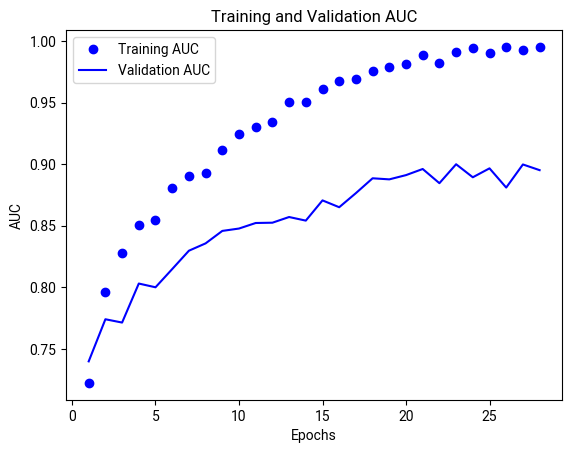

In [14]:
plot_training_validation_auc(history_dict, output_path, file_prefix)

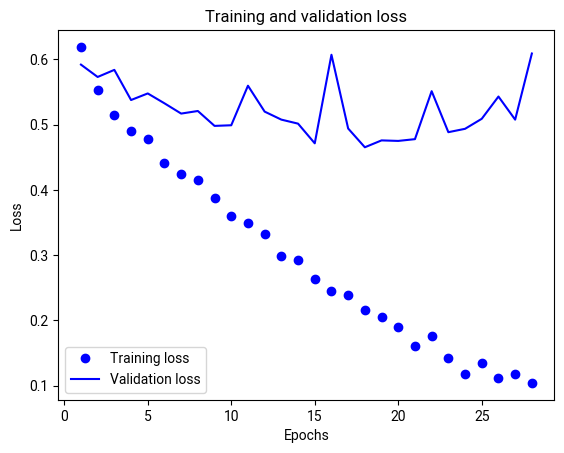

In [15]:
plot_training_validation_loss(history_dict, output_path, file_prefix)

In [16]:
results = model.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc_2: 0.8934 - loss: 0.4429 


In [17]:
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred)

y_classes = np.where(y_pred > 0.5, 1, 0)

tn, fp, fn, tp = confusion_matrix(y_test, y_classes).ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_classes)
sensitivity = recall_score(y_test, y_classes)  # TPR
specificity = tn / (tn + fp)  # TN

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("AUC:", test_auc)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.8544061302681992
Sensitivity: 0.8217821782178217
Specificity: 0.875
AUC: 0.8935643564356436


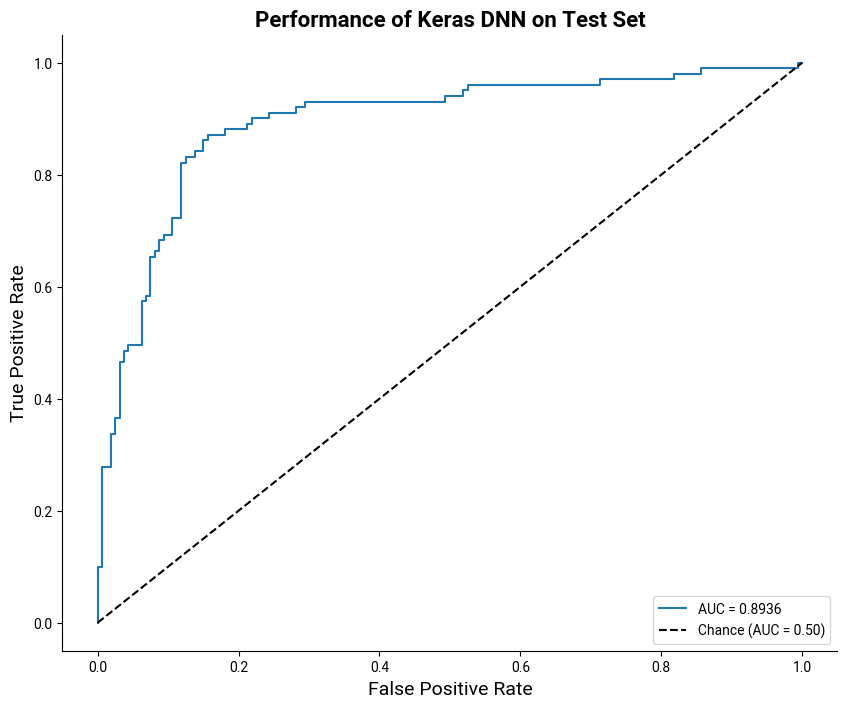

In [18]:
plot_roc_curve(fpr, tpr, test_auc, output_path, file_prefix)